<a href="https://colab.research.google.com/github/phongidoit/Computer_vision/blob/main/FaceReg2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/data ML/Facial.zip"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/data ML/Facial.zip
   creating: Facial/
   creating: Facial/Luong/
  inflating: Facial/Luong/Luong_000.png  
  inflating: Facial/Luong/Luong_001.png  
  inflating: Facial/Luong/Luong_002.png  
  inflating: Facial/Luong/Luong_003.png  
  inflating: Facial/Luong/Luong_004.png  
  inflating: Facial/Luong/Luong_005.png  
  inflating: Facial/Luong/Luong_006.png  
  inflating: Facial/Luong/Luong_007.png  
  inflating: Facial/Luong/Luong_008.png  
  inflating: Facial/Luong/Luong_009.png  
  inflating: Facial/Luong/Luong_010.png  
  inflating: Facial/Luong/Luong_011.png  
  inflating: Facial/Luong/Luong_012.png  
  inflating: Facial/Luong/Luong_013.png  
  inflating: Facial/Luong/Luong_014.png  
  inflating: Facial/Luong/Luong_015.png  
  inflating: Facial/Luong/Luong_016.png  
  inflating: Facial/Luong/Luong_017.png  
  inflating: Facial/Luong/Luong_018.png  
  inflating: Facial/Luong/Luong_019.png  
  inflating: Facial/Luong/Luong_02

Find the source of notebook here: https://github.com/timesler/facenet-pytorch/


In [2]:
#the notebook start here
!pip install facenet-pytorch

from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.2 MB/s eta 0:00:00


In [3]:
data_dir = "/content/Facial"

batch_size=32
epochs= 5
workers = 0 if os.name == 'nt' else 8

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)


Running on device: cpu


In [4]:

dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch 17 of 17

We don't need to use the classify because we only need it to create a vector for each face

In [5]:

model = InceptionResnetV1(
    classify=False,
    pretrained='vggface2',
).to(device)
#print(dataset.class_to_idx)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [6]:

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
"""

train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)


loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

"""

"\n\ntrain_inds = img_inds[:int(0.8 * len(img_inds))]\nval_inds = img_inds[int(0.8 * len(img_inds)):]\n\ntrain_loader = DataLoader(\n    dataset,\n    num_workers=workers,\n    batch_size=batch_size,\n    sampler=SubsetRandomSampler(train_inds)\n)\nval_loader = DataLoader(\n    dataset,\n    num_workers=workers,\n    batch_size=batch_size,\n    sampler=SubsetRandomSampler(val_inds)\n)\n\n\nloss_fn = torch.nn.CrossEntropyLoss()\nmetrics = {\n    'fps': training.BatchTimer(),\n    'acc': training.accuracy\n}\n\n"

In [7]:
#Training start here
"""
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('Initial')
print('-' * 10)
model.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()
"""

"\nwriter = SummaryWriter()\nwriter.iteration, writer.interval = 0, 10\n\nprint('Initial')\nprint('-' * 10)\nmodel.eval()\ntraining.pass_epoch(\n    resnet, loss_fn, val_loader,\n    batch_metrics=metrics, show_running=True, device=device,\n    writer=writer\n)\n\nfor epoch in range(epochs):\n    print('\nEpoch {}/{}'.format(epoch + 1, epochs))\n    print('-' * 10)\n\n    resnet.train()\n    training.pass_epoch(\n        resnet, loss_fn, train_loader, optimizer, scheduler,\n        batch_metrics=metrics, show_running=True, device=device,\n        writer=writer\n    )\n\n    resnet.eval()\n    training.pass_epoch(\n        resnet, loss_fn, val_loader,\n        batch_metrics=metrics, show_running=True, device=device,\n        writer=writer\n    )\n\nwriter.close()\n"

In [17]:
# skip training and go straight to validation and create embed vector for each face
from PIL import Image
import cv2
import glob

model.eval()
embeddings=[]
names=[]
for usr in os.listdir(data_dir+ '_cropped'):
  embeds=[]
  for file in glob.glob(os.path.join(data_dir+ '_cropped/')+usr+'/*.png'):
    #print(file)
    try:
      img=cv2.imread(file)
    #img = img[:, :, :3]
    except:
      print("Here")
      continue
    with torch.no_grad():
              embed = model(trans(img).unsqueeze(0).to(device))
              embeds.append(embed) 
  if len(embeds) == 0:
        continue 
  embedding = torch.cat(embeds).mean(0, keepdim=True) #dua ra trung binh cua 50 anh, kich thuoc [1,512]
  embeddings.append(embedding) # 1 cai list n cai [1,512]
  names.append(usr)   

embeddings = torch.cat(embeddings) #[n,512]
names = np.array(names)
torch.save(embeddings, "/content/faceslist.pth")
np.save("/content/usernames", names)


TypeError: ignored

In [46]:
embeddings.size()
torch.save(embeddings, "/content/faceslist.pth")
np.save("/content/usernames", names)

<IPython.core.display.Javascript object>

Saved to photo.jpg


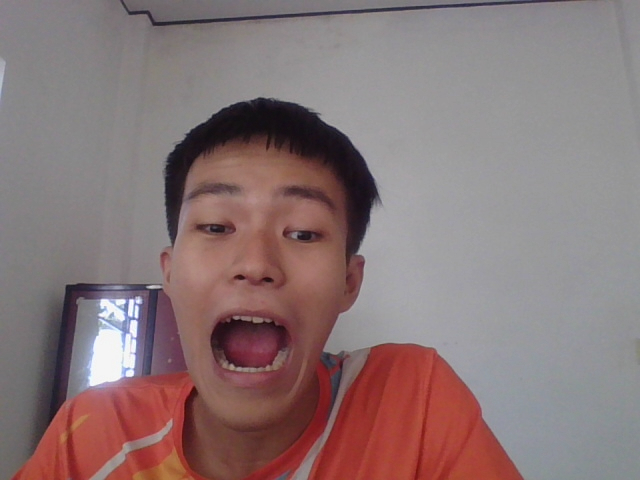

In [76]:
#take a new picture
#Take a real picture and compare
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=1):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

#RUN from here to recapture input image

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Name: Luong |	Confidence: 0.0406
Name: Phong |	Confidence: 0.6311


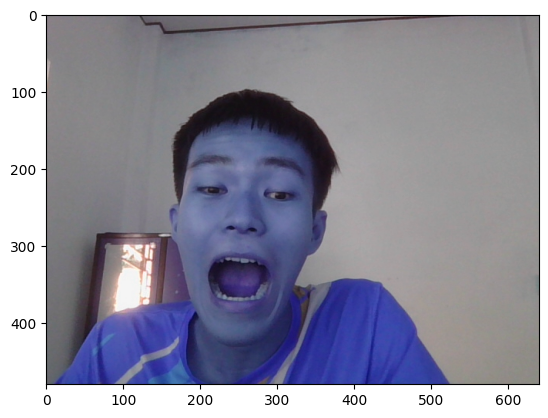

In [77]:
import math
import matplotlib.pyplot as plt

def cosine_similarity(out, sample):
  up1, down1, down2 = 0, 0, 0
  for i in range(len(out)):
    up1   += out[i] * sample[i]
    down1 += out[i]**2
    down2 += sample[i]**2
  return up1/(math.sqrt(down1)* math.sqrt(down2))  

#webcam image
im= cv2.imread("/content/photo.jpg")

#self_upload image
#im = cv2.imread("/content/Screenshot 2022-02-20 230505.png")

filename_crop = mtcnn(im)

if filename_crop is not None:
  result = model(filename_crop.reshape(1, 3, 160, 160))
  prob=[]
  for i in range(len(names)):
    prob.append(cosine_similarity(result[0],embeddings[i]))
  prob= np.array([ele.detach().numpy() for ele in prob],dtype=float)
  max_confidence = np.max(prob)
  #print("Name:",names[np.argmax(prob)], "|\tConfidence:",f'{max_confidence:.4f}')
  for i in range(len(names)):
    print("Name:",names[i], "|\tConfidence:",f'{prob[i]:.4f}')
  plt.figure(figsize=(8,8))  
  plt.imshow(im)
else:
  print("No face detected")
